This notebook calculates the classification accuracy with genes involved in peptidergic communication.

We perform classification at two levels of cell type annotations: `class` and `subclass`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from cci.utils import get_adata, get_available_lr
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from cci.utils import get_adata
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import StratifiedKFold
import warnings
from anndata import ImplicitModificationWarning
warnings.filterwarnings("ignore", category=ImplicitModificationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=0.8, rc=custom_params)
%config InlineBackend.figure_format='retina'

In [2]:
# Fetch merfish data from only VISp.
# Full set of cells that are part of the VISp region
adata_VISp = get_adata("VISp")

# 2 lists below contain classes and subclasses containing neuronal cells
# Classes and subclasses whose cell count is less than 1% of total cells in the VISp region have been excluded
classes_to_keep_VISp = ["01 IT-ET Glut", "02 NP-CT-L6b Glut", "06 CTX-CGE GABA", "07 CTX-MGE GABA"]

subclasses_to_keep_VISp = [
    "006 L4/5 IT CTX Glut",
    "007 L2/3 IT CTX Glut",
    "030 L6 CT CTX Glut",
    "004 L6 IT CTX Glut",
    "022 L5 ET CTX Glut",
    "052 Pvalb Gaba",
    "005 L5 IT CTX Glut",
    "053 Sst Gaba",
    "032 L5 NP CTX Glut",
    "046 Vip Gaba",
    "049 Lamp5 Gaba",
]


In [3]:
def display_label(adata):
    df_1 = adata.obs[["class"]].value_counts().to_frame().sort_values(by="class").reset_index()
    df_1 = df_1.rename(columns = {"count":"class_count"})

    df_2 = adata.obs[["class", "subclass"]].value_counts().to_frame().sort_values(by="class").reset_index()
    df_2 = df_2.rename(columns = {"count":"subclass_count"})

    df = df_2.merge(df_1, how="left", left_on="class", right_on="class")
    df = df.sort_values(['class_count', 'subclass_count'], ascending=[False, False]).reset_index(drop=True)

    return df

In [4]:
# Subsetting the full set of cells to only include classes and subclasses shown in 2 lists above

# Distribution of dataset after subsetting
print("Before subsetting")
#display_label(adata_VISp)

# use pandas styler to highlight the rows that will be removed with a light red background color
# using Styler.map_index
df = display_label(adata_VISp)
df.style.apply(lambda x: ['background: lightcoral' if x.name not in classes_to_keep_VISp and x.name not in subclasses_to_keep_VISp else '' for i in x], axis=1)
display(df)


Before subsetting


,class,subclass,subclass_count,class_count
0,01 IT-ET Glut,006 L4/5 IT CTX Glut,16551,34168
1,01 IT-ET Glut,007 L2/3 IT CTX Glut,9865,34168
2,01 IT-ET Glut,004 L6 IT CTX Glut,3136,34168
3,01 IT-ET Glut,022 L5 ET CTX Glut,2531,34168
4,01 IT-ET Glut,005 L5 IT CTX Glut,1921,34168
5,01 IT-ET Glut,001 CLA-EPd-CTX Car3 Glut,111,34168
6,01 IT-ET Glut,003 L5/6 IT TPE-ENT Glut,28,34168
7,01 IT-ET Glut,002 IT EP-CLA Glut,22,34168
8,01 IT-ET Glut,015 ENTmv-PA-COAp Glut,1,34168
9,01 IT-ET Glut,018 L2 IT PPP-APr Glut,1,34168


In [5]:
print("After subsetting to only include classes listed above")

adata_VISp_neuronal = adata_VISp[adata_VISp.obs['class'].isin(classes_to_keep_VISp)]

display_label(adata_VISp_neuronal)

After subsetting to only include classes listed above


,class,subclass,subclass_count,class_count
0,01 IT-ET Glut,006 L4/5 IT CTX Glut,16551,34168
1,01 IT-ET Glut,007 L2/3 IT CTX Glut,9865,34168
2,01 IT-ET Glut,004 L6 IT CTX Glut,3136,34168
3,01 IT-ET Glut,022 L5 ET CTX Glut,2531,34168
4,01 IT-ET Glut,005 L5 IT CTX Glut,1921,34168
5,01 IT-ET Glut,001 CLA-EPd-CTX Car3 Glut,111,34168
6,01 IT-ET Glut,003 L5/6 IT TPE-ENT Glut,28,34168
7,01 IT-ET Glut,002 IT EP-CLA Glut,22,34168
8,01 IT-ET Glut,021 L4 RSP-ACA Glut,1,34168
9,01 IT-ET Glut,018 L2 IT PPP-APr Glut,1,34168


In [6]:
print("After subsetting to only include classes and subclasses listed above")

adata_VISp_neuronal = adata_VISp_neuronal[adata_VISp_neuronal.obs['subclass'].isin(subclasses_to_keep_VISp)]

display_label(adata_VISp_neuronal)

After subsetting to only include classes and subclasses listed above


,class,subclass,subclass_count,class_count
0,01 IT-ET Glut,006 L4/5 IT CTX Glut,16551,34004
1,01 IT-ET Glut,007 L2/3 IT CTX Glut,9865,34004
2,01 IT-ET Glut,004 L6 IT CTX Glut,3136,34004
3,01 IT-ET Glut,022 L5 ET CTX Glut,2531,34004
4,01 IT-ET Glut,005 L5 IT CTX Glut,1921,34004
5,02 NP-CT-L6b Glut,030 L6 CT CTX Glut,7506,8345
6,02 NP-CT-L6b Glut,032 L5 NP CTX Glut,839,8345
7,07 CTX-MGE GABA,052 Pvalb Gaba,2113,3571
8,07 CTX-MGE GABA,053 Sst Gaba,1458,3571
9,06 CTX-CGE GABA,046 Vip Gaba,713,1287


In [7]:
# full list of ligands and receptors as per Smith et al. 2019
ligands = [['Npy'],[ 'Sst'], ['Vip'], ['Tac2'], ['Cck'], ['Penk'], ['Crh'], ['Cort'], ['Tac1'], ['Pdyn'], ['Pthlh'], ['Pnoc'], ['Trh'], ['Grp'], ['Rln1'], ['Adcyap1'], ['Nts'], ['Nmb']]
receptors = [["Npy1r", "Npy2r", "Npy5"], ["Sstr1", "Sstr2", "Sstr3", "Sstr4" ], ["Vipr1", "Vipr2"], ["Tacr3"], ["Cckbr"], ["Oprd1", "Oprm1"], ["Crhr1", "Crhr2"], ["Sstr1", "Sstr2", "Sstr3", "Sstr4"], ["Tacr1"], ["Oprd1", "Oprk1", "Oprm1"], ["Pth1r"], ["Oprl1"], ["Trhr", "Trhr2"], ["Grpr"], ["Rxfp1", "Rxfp2", "Rxfp3"], ["Adcyap1r1", "Vipr1", "Vipr2"], ["Ntsr1", "Ntsr2"], ["Nmbr"]]

ligand_index, receptor_index = get_available_lr(adata_VISp_neuronal) 
# returns a dictionary containing ligand and receptor genes available in dataset
# dictionary key is an index corresponding to the ligand-receptor pair
for i in range(len(ligands)):
    if i in ligand_index and i in receptor_index: # both ligand and receptor corresponding to a pair exists
        adjs = []
        for ligand in ligand_index[i]:
            for receptor in receptor_index[i]:
                print(ligand, receptor) # Ligand and receptor pairs that exist in the dataset 

Tac2 Tacr3
Penk Oprd1
Pdyn Oprd1
Pdyn Oprk1
Grp Grpr


In [8]:
# Train test split for class prediction
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_idx_class, test_idx_class = next(skf.split(np.arange(adata_VISp_neuronal.shape[0]), adata_VISp_neuronal.obs["class"].values))

# Train test split for subclass prediction
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_idx_subclass, test_idx_subclass = next(skf.split(np.arange(adata_VISp_neuronal.shape[0]), adata_VISp_neuronal.obs["subclass"].values))

In [9]:
def linear_predict(y_str, x, adata, random_state, train_idx, test_idx):
    y = adata.obs.loc[:, y_str]
    x_train = x[train_idx, :]
    x_test = x[test_idx, :]
    y_train = y[train_idx]
    y_test = y[test_idx]
    # x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=random_state)

    # scale input - regularization with logistic regression is sensitive to scale.
    model = make_pipeline(StandardScaler(), LogisticRegressionCV(random_state=random_state))
    model.fit(x_train, y_train)
    y_pred_train = model.predict(x_train)
    y_pred_test = model.predict(x_test)
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)

    return acc_train, acc_test, [y_test, y_pred_test]


def rand_predict(y_str, x, adata, train_idx, test_idx):
    y = adata.obs.loc[:, y_str]
    x_train = x[train_idx, :]
    x_test = x[test_idx, :]
    y_train = y[train_idx]
    y_test = y[test_idx]

    # x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    strategies = ["prior", "stratified", "uniform"]
    test_scores = {}
    for s in strategies:
        dclf = DummyClassifier(strategy=s, random_state=0)
        dclf.fit(x_train, y_train)
        score = dclf.score(x_test, y_test)
        test_scores[s] = np.round(score, 2)
    return test_scores


#### Class classification on VISp dataset

In [10]:
def gene_label_prediction_classification_report(adata, genelist, train_idx, test_idx, y_str, random_state):
    df = pd.DataFrame(adata[:, genelist].X.todense())
    acc_train, acc_test, [y_test, y_pred_test] = linear_predict(y_str, df.to_numpy(), adata, random_state, train_idx, test_idx)

    print(f"Train Accuracy: {acc_train:0.3f} | Test Accuracy: {acc_test:0.3f}")
    classificationReport = classification_report(
        y_test,
        y_pred_test,
        target_names=list(map(str, np.unique(y_test))),
        output_dict=True,
        zero_division=0,
    )

    df_cr = pd.DataFrame(classificationReport).transpose().sort_values("support", ascending=False)
    df_cr["support"] /= df_cr.loc["macro avg", "support"]

    return df_cr.round(2), y_test, y_pred_test

In [11]:
# List of all genes from the 4 LR communication pairs found above
lr_genes_combined = ["Tac2", "Tacr3", 'Penk', 'Oprd1', "Pdyn", "Oprd1", "Oprk1", "Grp", "Grpr"]
#Predicting cell class with gene expression of the above list of cells. Logistic Regression with cross validation is used for prediction.
all_lr_class, y_test_class, y_pred_test_class = gene_label_prediction_classification_report(adata_VISp_neuronal, lr_genes_combined, train_idx_class, test_idx_class, "class", random_state = 42)

# Classification report showing per class metrics for prediction with genes from all 4 LR communication pairs
display(all_lr_class)

Train Accuracy: 0.812 | Test Accuracy: 0.807


,precision,recall,f1-score,support
macro avg,0.81,0.59,0.65,1.00
weighted avg,0.80,0.81,0.78,1.00
01 IT-ET Glut,0.81,0.96,0.88,0.72
02 NP-CT-L6b Glut,0.70,0.29,0.41,0.18
07 CTX-MGE GABA,0.86,0.74,0.79,0.08
06 CTX-CGE GABA,0.87,0.37,0.52,0.03
accuracy,0.81,0.81,0.81,0.00


#### Subclass classification on VISp dataset

In [12]:
#Predicting cell subclass with gene expression of the above list of cells. 
all_lr_subclass, y_test_subclass, y_pred_test_subclass = gene_label_prediction_classification_report(adata_VISp_neuronal, lr_genes_combined, train_idx_subclass, test_idx_subclass, "subclass", random_state = 42)

Train Accuracy: 0.522 | Test Accuracy: 0.528


In [13]:
# Classification report showing per subclass metrics for prediction with genes from all 4 LR communication pairs
all_lr_subclass

,precision,recall,f1-score,support
macro avg,0.52,0.37,0.37,1.00
weighted avg,0.49,0.53,0.47,1.00
006 L4/5 IT CTX Glut,0.52,0.85,0.64,0.35
007 L2/3 IT CTX Glut,0.49,0.43,0.45,0.21
030 L6 CT CTX Glut,0.49,0.43,0.46,0.16
004 L6 IT CTX Glut,0.49,0.05,0.09,0.07
022 L5 ET CTX Glut,0.30,0.04,0.07,0.05
052 Pvalb Gaba,0.77,0.81,0.79,0.04
005 L5 IT CTX Glut,0.00,0.00,0.00,0.04
053 Sst Gaba,0.82,0.59,0.68,0.03


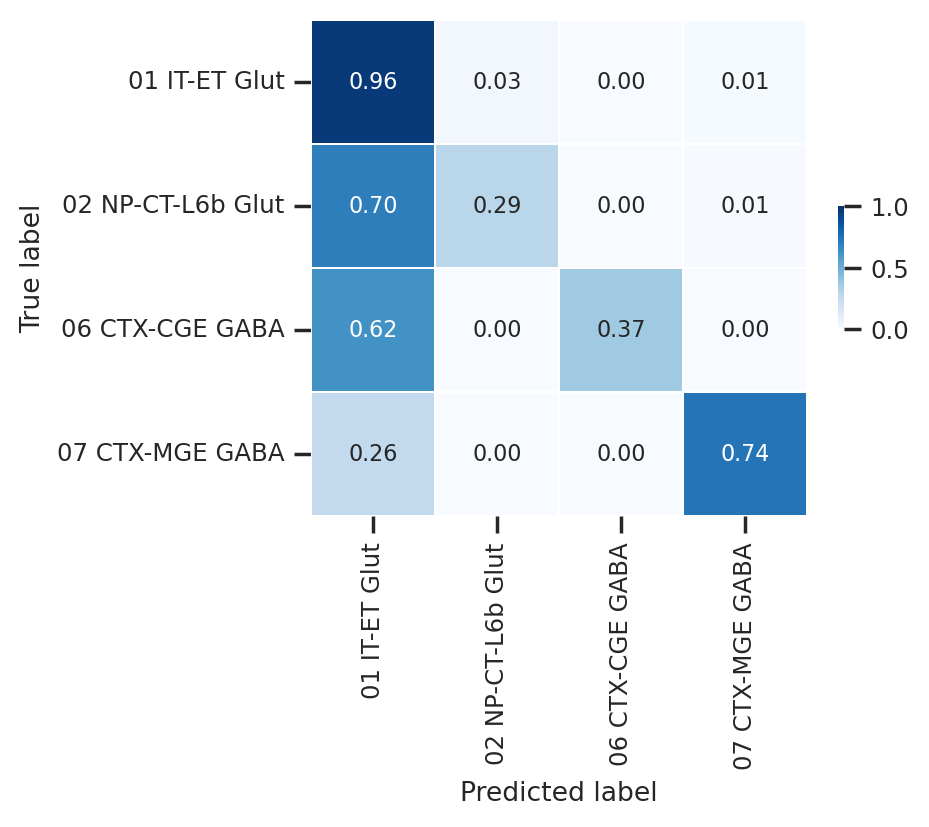

In [14]:
def conf_matrix_plot(adata, y_test, y_pred_test):
    cell_type_list = np.unique(y_test)
    matrix = confusion_matrix(y_test, y_pred_test, labels = cell_type_list)

    matrix = matrix.astype("float") / matrix.sum(axis=1)[:, np.newaxis]
    df = pd.DataFrame(matrix, index=cell_type_list[:matrix.shape[0]], columns=cell_type_list[:matrix.shape[1]])
    f, ax = plt.subplots(1,1, figsize=(4, 4))
    sns.heatmap(df, cmap='Blues', annot=True ,fmt=".2f", 
                annot_kws={'size': 8}, 
                vmin=0, vmax=1, ax=ax, 
                linewidths=0.1, 
                square=True,
                cbar_kws={'shrink': .2}, 
                xticklabels=1, 
                yticklabels=1)
    ax.set(xlabel='Predicted label', ylabel='True label')    
    plt.show()

conf_matrix_plot(adata_VISp_neuronal, y_test_class, y_pred_test_class)

In [15]:
# Using a dummy classifier to randomly predict cell class. 3 strategies are used.
rand = rand_predict("subclass", pd.DataFrame(adata_VISp_neuronal[:,lr_genes_combined].X.todense()).to_numpy(), adata_VISp_neuronal, train_idx_subclass, test_idx_subclass)
rand

{'prior': 0.35, 'stratified': 0.21, 'uniform': 0.09}

In [16]:
# List of genes from the each of the 4 LR communication pairs found above
lr_genelist = [ ["Tac2", "Tacr3"], ['Penk', 'Oprd1'], ["Pdyn", "Oprd1", "Oprk1"], ["Grp", "Grpr"]]

#Predicting cell class with gene expression using each of the 4 sets of genes. 

lr0, _, _ = gene_label_prediction_classification_report(adata_VISp_neuronal, lr_genelist[0], train_idx_class, test_idx_class, "class", random_state = 42)
lr1, _, _ = gene_label_prediction_classification_report(adata_VISp_neuronal, lr_genelist[1], train_idx_class, test_idx_class, "class", random_state = 42)
lr2, _, _ = gene_label_prediction_classification_report(adata_VISp_neuronal, lr_genelist[2], train_idx_class, test_idx_class, "class", random_state = 42)
lr3, _, _ = gene_label_prediction_classification_report(adata_VISp_neuronal, lr_genelist[3], train_idx_class, test_idx_class, "class", random_state = 42)

Train Accuracy: 0.726 | Test Accuracy: 0.725
Train Accuracy: 0.768 | Test Accuracy: 0.767
Train Accuracy: 0.767 | Test Accuracy: 0.766
Train Accuracy: 0.746 | Test Accuracy: 0.746


In [17]:
# Classification report showing per subclass metrics for prediction with genes from the second LR pair
lr1

,precision,recall,f1-score,support
macro avg,0.61,0.45,0.46,1.00
weighted avg,0.63,0.77,0.68,1.00
01 IT-ET Glut,0.76,0.99,0.86,0.72
02 NP-CT-L6b Glut,0.00,0.00,0.00,0.18
07 CTX-MGE GABA,0.84,0.68,0.75,0.08
06 CTX-CGE GABA,0.82,0.14,0.24,0.03
accuracy,0.77,0.77,0.77,0.00
